**types of simulators**
- qasm simulator which executes the quantum circuits with multiple shots to smulate a noisy backend quantum system
- statevector simulator which provides the state vector of the quantm circuit
- unitary simulator which provides the unitary matrix of the quantum circuit being executed
- pulse simulator which simulates pulse schedules to execute directly to the various channels on the hardware

In [2]:
from qiskit_aer import Aer

In [3]:
Aer.backends()

[AerSimulator('aer_simulator'),
 AerSimulator('aer_simulator_statevector'),
 AerSimulator('aer_simulator_density_matrix'),
 AerSimulator('aer_simulator_stabilizer'),
 AerSimulator('aer_simulator_matrix_product_state'),
 AerSimulator('aer_simulator_extended_stabilizer'),
 AerSimulator('aer_simulator_unitary'),
 AerSimulator('aer_simulator_superop'),
 QasmSimulator('qasm_simulator'),
 StatevectorSimulator('statevector_simulator'),
 UnitarySimulator('unitary_simulator')]

In [4]:
from dotenv import load_dotenv
import os
load_dotenv()  # take environment variables from .env.
from qiskit_ibm_runtime import QiskitRuntimeService, fake_provider

provider = QiskitRuntimeService(channel="ibm_quantum", token=os.getenv('QISKIT_IBM_TOKEN'))

In [5]:
provider.backends(simulator=False)

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyiv')>,
 <IBMBackend('ibm_sherbrooke')>]

In [6]:
provider.backends(simulator=True)

[]

In [7]:
from qiskit import QuantumCircuit
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)
qc.measure([0,1], [0,1])

In [8]:
qc.draw()

┌───┐     ┌─┐   
q_0: ┤ H ├──■──┤M├───
     └───┘┌─┴─┐└╥┘┌─┐
q_1: ─────┤ X ├─╫─┤M├
          └───┘ ║ └╥┘
c: 2/═══════════╩══╩═
                0  1

### Qasm simulator

available simulation methods
- statevector: it allows ideal circuit measurements at the end of quantum circuit. in addition each shot that executes the circuit can sample random noise from noise modes to provide noisy simulations
- density_matrix: gives density matrix simulation which similar to the statevector, samples the quantum circuits with measurements given at the end of each circuit
- matrix_product_state: tensor-network statevector simulator that leverages a matrix product state as the representation of the state
- automatic: if no method is set then this method automatically selcts based on the no of qubits, quantum circuit, and noise model

`backend_options`
- method: the above ones
- precision: sets floating point to either single or double precision (default=double)
- zero_threshold: this truncates values to 0
- validation_threshold: is used to verify if the initial states of the quantum circuit are valid (default=1e-8)
- max_parallel_threads: this is used to set the max no of parallel cpu cores (default=0)
- max_parallel_experiments: the max no of `Qobj` circuits in parallel not to exceed the max parallelthreads (default=1 aka disable) and if 0 it will be maximally set
- max_parallel_shots: default is 0 which means it will be max_paralel_threads. and if 1 then its disabled
- max_memory_mb: the max memory in MB that can be used by the simulator (default=0) the max value is locked at /2 the size of the system memory

In [9]:
from qiskit_aer import QasmSimulator, AerSimulator

In [10]:
simulator = QasmSimulator()
res = simulator.run(qc, shots=10,method='statevector', memory=True)

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Circuit circuit-186 contains invalid instructions {"instructions": {save_unitary}} for "statevector" method.Circuit circuit-186 contains invalid parameters  for "statevector" method.
Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Circuit circuit-190 contains invalid instructions {"instructions": {save_unitary}} for "statevector" method.Circuit circuit-190 contains invalid parameters  for "statevector" method.


In [11]:
res.status()

<JobStatus.DONE: 'job has successfully run'>

In [12]:
res.result().get_counts()

{'00': 3, '11': 7}

In [13]:
res.result().get_memory(qc)

['11', '00', '11', '11', '00', '11', '11', '11', '00', '11']

### set non default initialize qubit values

In [14]:
import numpy as np

qc_init = QuantumCircuit(2,2)
init_qubits=[0,1] # select the qubits by their index which you want to initialize
qc_init.initialize([1, 0, 0, 1]/np.sqrt(2), init_qubits)

# For the array [1,0,0,1]:
# Position 0 (1): Amplitude for |00⟩
# Position 1 (0): Amplitude for |01⟩
# Position 2 (0): Amplitude for |10⟩
# Position 3 (1): Amplitude for |11⟩

qc_init.measure(range(2), range(2))
qc_init.decompose().draw()

┌─────────────────────────────────────────┐┌─┐   
q_0: ─|0>─┤0                                        ├┤M├───
          │  State Preparation(0.70711,0,0,0.70711) │└╥┘┌─┐
q_1: ─|0>─┤1                                        ├─╫─┤M├
          └─────────────────────────────────────────┘ ║ └╥┘
c: 2/═════════════════════════════════════════════════╩══╩═
                                                      0  1

In [15]:
simulator = AerSimulator()
res = simulator.run(qc_init, shots=10, memory=True).result()
res.get_memory(qc_init)

['11', '00', '00', '00', '00', '00', '00', '11', '00', '00']

In [16]:
res.get_counts() # values are same!!

{'00': 8, '11': 2}

In [17]:
qc_init_2 = QuantumCircuit(4,4)
# initializing 3 qubits with an 8-element array, representing the amplitudes for all possible 3-qubit states (|000⟩, |001⟩, |010⟩, etc.).
qc_init_2.initialize([0, 1, 0, 1, 0, 1, 0, 1]/np.sqrt(4), [1,2,3])
qc_init_2.barrier(range(4))
qc_init_2.measure(qubit=range(4), cbit=range(4))

In [18]:
qc_init_2.decompose().draw()

░ ┌─┐         
q_0: ─────────────────────────────────────────────────────░─┤M├─────────
          ┌─────────────────────────────────────────────┐ ░ └╥┘┌─┐      
q_1: ─|0>─┤0                                            ├─░──╫─┤M├──────
          │                                             │ ░  ║ └╥┘┌─┐   
q_2: ─|0>─┤1 State Preparation(0,0.5,0,0.5,0,0.5,0,0.5) ├─░──╫──╫─┤M├───
          │                                             │ ░  ║  ║ └╥┘┌─┐
q_3: ─|0>─┤2                                            ├─░──╫──╫──╫─┤M├
          └─────────────────────────────────────────────┘ ░  ║  ║  ║ └╥┘
c: 4/════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                             0  1  2  3

In [19]:
simulator = AerSimulator()
res = simulator.run(qc_init_2, memory=True).result()
res.get_counts()

{'0110': 251, '0010': 237, '1010': 276, '1110': 260}

In [20]:
from qiskit.visualization import plot_histogram

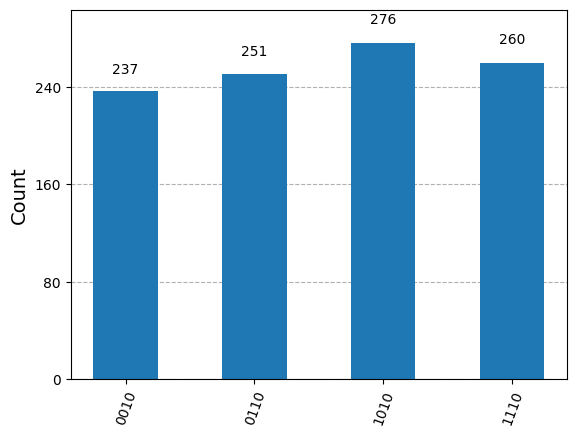

In [21]:
plot_histogram(res.get_counts())

you can see least significant bit q_0 is always 0 and rest are set according

now lets flip the results

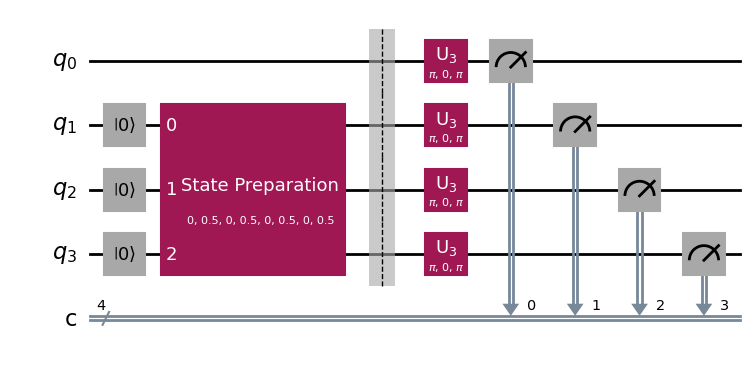

In [22]:
qc_init_3 = QuantumCircuit(4,4)
# initializing 3 qubits with an 8-element array, representing the amplitudes for all possible 3-qubit states (|000⟩, |001⟩, |010⟩, etc.).
qc_init_3.initialize([0, 1, 0, 1, 0, 1, 0, 1]/np.sqrt(4), [1,2,3])
qc_init_3.barrier(range(4))
for idx in range(4):
    qc_init_3.x(idx)
qc_init_3.measure(qubit=range(4), cbit=range(4))
qc_init_3.decompose().draw('mpl')

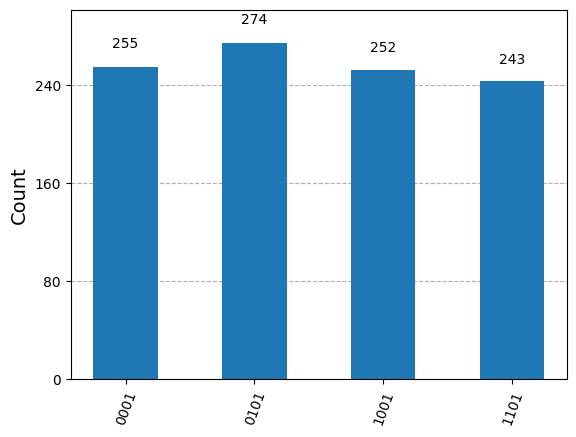

In [23]:
res = simulator.run(qc_init_3, memory=True).result()
res.get_counts()
plot_histogram(res.get_counts())

In [24]:
# Running circuits on the statevector simulator

qc = QuantumCircuit(2)
qc.h(0)
qc.h(1)
qc.save_statevector()
qc.draw()

┌───┐ statevector 
q_0: ┤ H ├──────░──────
     ├───┤      ░      
q_1: ┤ H ├──────░──────
     └───┘      ░

In [25]:
from qiskit_aer import AerSimulator
backend = AerSimulator()
res = backend.run(qc).result()
res.get_statevector(qc)

Statevector([0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j],
            dims=(2, 2))


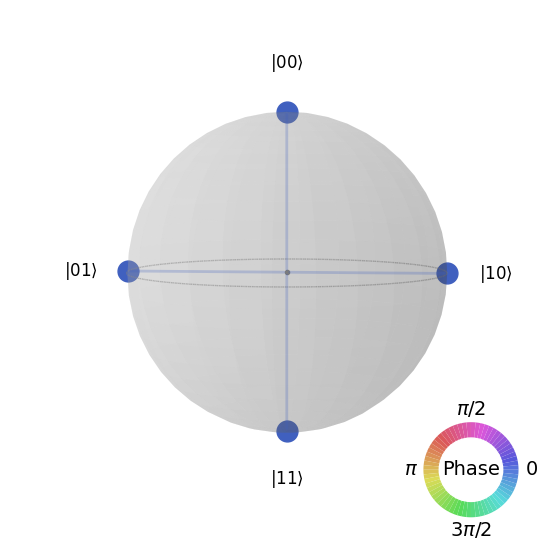

In [26]:
from qiskit.visualization import plot_state_qsphere, plot_state_city
plot_state_qsphere(res.get_statevector(qc))

In [27]:
qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)
qc.save_statevector()

statevector = backend.run(qc).result().get_statevector(qc)

In [28]:
statevector

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


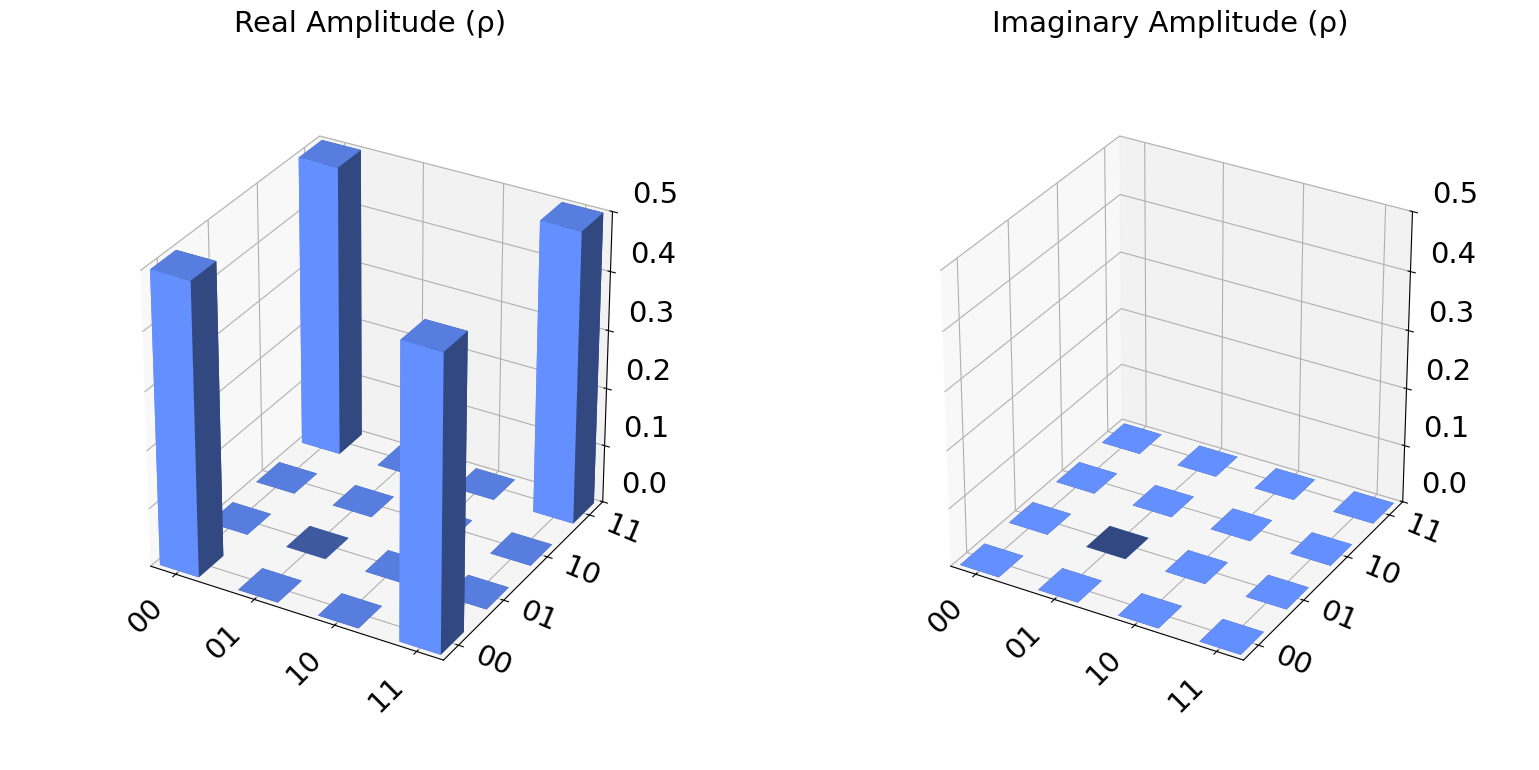

In [29]:
plot_state_city(statevector)

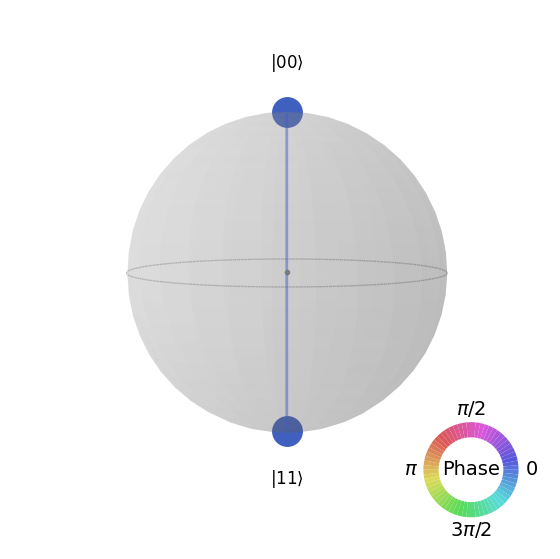

In [30]:
plot_state_qsphere(statevector)

### Unitary simulator

> it builds out the unitary matrics by stepping through the circuit and applying each gate to the initial state of the circuit 

no of shots = 1

no noise models, no reset | meas

In [32]:
qc = QuantumCircuit(1)
qc.h(0)

from qiskit_aer import UnitarySimulator

res = UnitarySimulator().run(qc).result()

In [33]:
res.get_unitary()

Operator([[ 0.70710678+0.00000000e+00j,  0.70710678-8.65956056e-17j],
          [ 0.70710678+0.00000000e+00j, -0.70710678+8.65956056e-17j]],
         input_dims=(2,), output_dims=(2,))


In [34]:
qc = QuantumCircuit(1)
qc.h(0)
qc.z(0)


from qiskit_aer import UnitarySimulator

res = UnitarySimulator().run(qc).result()

In [35]:
res.get_unitary()

Operator([[ 0.70710678+0.00000000e+00j,  0.70710678-8.65956056e-17j],
          [-0.70710678+0.00000000e+00j,  0.70710678-8.65956056e-17j]],
         input_dims=(2,), output_dims=(2,))


> When calculating the unitay matrix we place the unitatry matrices of the each gate we add from right to left. we will calculate the unitary matrix in the $$ZH = U$$ where U is unitary matrix